We study the behavior of the OV circuits of the top dontsay heads.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import functools
import gc

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import ablation, datasets, decomp, prompt_data, utils, vocab

### Load model

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
)

with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

    _, tmp_cache = tl_model.run_with_cache("hi")
    LABELS = np.array(
        decomp.get_all_resid_components(
            tl_model=tl_model, cache=tmp_cache, pos=-1, batch_idx=0
        ).labels
    )
    print(LABELS[:5])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions
['EMBED' 'L0H0ATN' 'L0H1ATN' 'L0H2ATN' 'L0H3ATN']


### Load data

In [4]:
df = pd.read_pickle(
    utils.get_repo_root() / "data" / "counterfact_processed.pkl"
)
df.keys()

Index(['case_id', 'pararel_idx', 'relation_id', 'subject', 'target_new_str',
       'target_true_str', 'fact_prefix', 'irrelevant_word', 'prompt_c',
       'prompt_nc0', 'prompt_nc1', 'p_correct_c', 'p_correct_nc0',
       'p_correct_nc1', 'lo_correct_c', 'lo_correct_nc0', 'lo_correct_nc1',
       'log_bf0', 'log_bf1', 'lo_correct_c_nc0', 'lo_correct_c_nc1',
       'lo_correct_nc0_c', 'lo_correct_nc1_c', 'lo_correct_c_nc0_dcum',
       'lo_correct_c_nc1_dcum', 'lo_correct_nc0_c_dcum',
       'lo_correct_nc1_c_dcum', 'lo_correct_c_nc0_cum', 'lo_correct_c_nc1_cum',
       'lo_correct_nc0_c_cum', 'lo_correct_nc1_c_cum'],
      dtype='object')

In [5]:
log_bf_nc_c = np.concatenate(
    [
        np.stack(df.lo_correct_nc0_c) - df.lo_correct_nc0.to_numpy()[:, None],
        np.stack(df.lo_correct_nc1_c) - df.lo_correct_nc1.to_numpy()[:, None],
    ]
)
log_bf_c_nc = np.concatenate(
    [
        np.stack(df.lo_correct_c_nc0) - df.lo_correct_c.to_numpy()[:, None],
        np.stack(df.lo_correct_c_nc1) - df.lo_correct_c.to_numpy()[:, None],
    ]
)
print(log_bf_c_nc.shape, log_bf_nc_c.shape)

COMPONENT_ORDER = np.argsort(log_bf_nc_c.mean(axis=0))
LABELS_ORDERED = LABELS[COMPONENT_ORDER]
ATN_HEAD_LABEL_MASK = np.array([("ATN" in label) for label in LABELS_ORDERED])
print(LABELS_ORDERED[:10])

ATTN_HEAD_LOCS = [
    (int(label.split("H")[0][1:]), int(label.split("H")[1][:-3]))
    for label in LABELS_ORDERED[ATN_HEAD_LABEL_MASK]
]
print(ATTN_HEAD_LOCS[:5])

(6152, 1057) (6152, 1057)
['L18H9ATN' 'L27H29ATN' 'L31MLP' 'L26H9ATN' 'L25MLP' 'L25H12ATN'
 'L19H23ATN' 'L22H20ATN' 'L23H19ATN' 'L28H7ATN']
[(18, 9), (27, 29), (26, 9), (25, 12), (19, 23)]


### Analyze OV circuits

In [6]:
def logit_softmax(xs: torch.Tensor) -> torch.Tensor:
    log_probs = xs.log_softmax(dim=-1)

    mx = xs.max(dim=-1)

    xs_shifted = xs - mx.values[:, None]
    log_denom = xs_shifted.logsumexp(dim=-1)
    xs_shifted[torch.arange(xs.shape[0]), mx.indices] = xs_shifted[:, -1]
    log_numer = xs_shifted[:, :-1].logsumexp(dim=-1)

    log1m_probs_max = log_numer - log_denom

    logits = log_probs.exp().logit()
    logits[torch.arange(xs.shape[0]), mx.indices] = (
        log_probs[torch.arange(xs.shape[0]), mx.indices] - log1m_probs_max
    )

    return logits


def get_ov_resp_matrix(layer: int, head: int):
    """Returns a matrix in units of log_e-prob."""
    W_O = tl_model.W_O[layer, head]
    W_V = tl_model.W_V[layer, head]

    with torch.no_grad():
        raw_logits = utils.unembed(
            tl_model.W_E @ W_V @ W_O, tl_model=tl_model
        ).float()

        logits = logit_softmax(raw_logits)

        return logits


def plot_ov_resp_matrix(
    layer: int,
    head: int,
    top_tokens: int = 3,
    largest: bool = False,
):
    log10_resp_mat = get_ov_resp_matrix(layer=layer, head=head) / np.log(10)
    log10_resp_diag = log10_resp_mat.diag()

    # utils.print_most_likely_tokens(
    #     log10_resp_diag,
    #     tl_model,
    #     n_tokens=viz_tokens,
    #     largest=False,
    # )

    top_tokens = torch.topk(
        log10_resp_diag, top_tokens, largest=largest
    ).indices

    log10_bf = log_bf_nc_c.mean(axis=0)[
        list(LABELS).index(f"L{layer}H{head}ATN")
    ] / np.log(10)
    plt.text(
        0.05,
        0.95,
        "\n".join(
            [
                f"L{layer}H{head}",
                f"$\log_{{10}}$ B.f.: {log10_bf:.3f}",
                "Top tokens:",
            ]
            + [
                f"{tl_model.to_string(tok.item())} ({log10_resp_diag[tok.item()]:.3f})"
                for tok in top_tokens
            ]
        ),
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
    )

    plt.hist(
        log10_resp_diag.cpu().numpy(),
        bins=128,
        density=True,
        alpha=0.5,
        label="Diagonal",
    )
    utils.plot_hist_from_tensor(
        xs=log10_resp_mat.flatten(),
        anti_xs=log10_resp_diag,
        bins=256,
        density=True,
        alpha=0.5,
        label="Off-diagonal",
        color="tab:orange",
    )
    plt.axvline(
        np.log10(1 / tl_model.cfg.d_vocab),
        color="black",
        linestyle="dotted",
        label="$\log_{10}$(1 / d_vocab)",
    )

  0%|          | 0/9 [00:00<?, ?it/s]

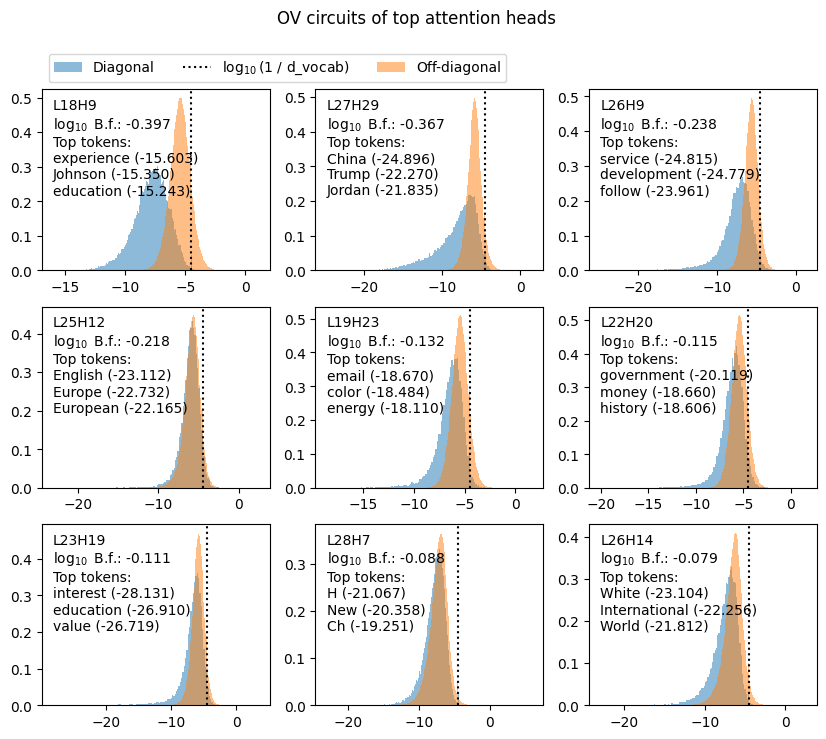

  0%|          | 0/9 [00:00<?, ?it/s]

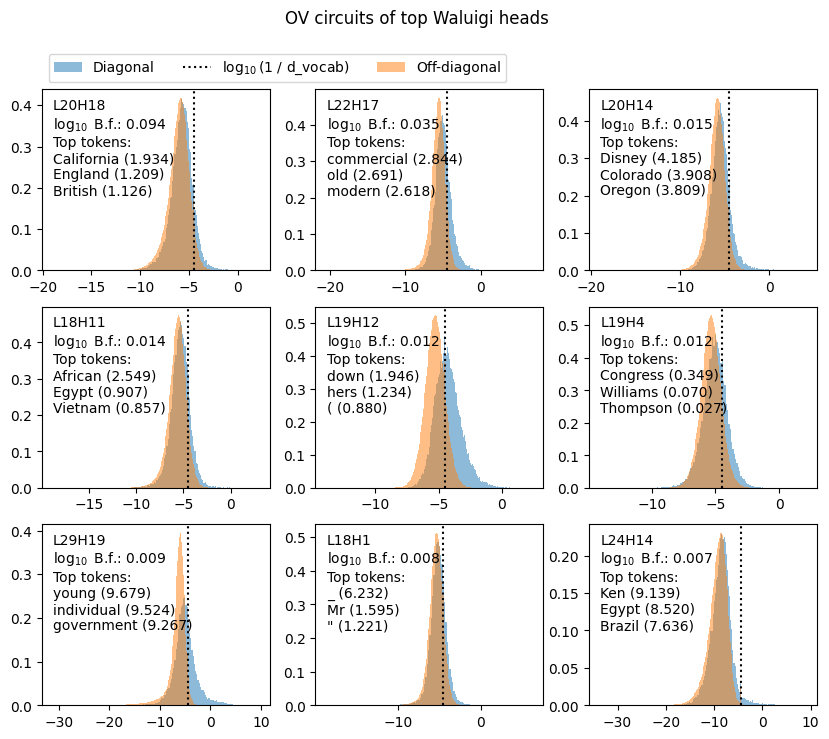

In [7]:
plt.figure(figsize=(10, 8))
plt.suptitle("OV circuits of top attention heads")
for i in tqdm(range(9)):
    plt.subplot(3, 3, i + 1)

    layer, head = ATTN_HEAD_LOCS[i]
    plot_ov_resp_matrix(layer=layer, head=head, top_tokens=3)
    if i == 0:
        plt.legend(bbox_to_anchor=(0, 1), loc="lower left", ncol=3)

plt.show()

plt.figure(figsize=(10, 8))
plt.suptitle("OV circuits of top Waluigi heads")
for i in tqdm(range(9)):
    plt.subplot(3, 3, i + 1)

    layer, head = ATTN_HEAD_LOCS[-i - 1]
    plot_ov_resp_matrix(layer=layer, head=head, top_tokens=3, largest=True)
    if i == 0:
        plt.legend(bbox_to_anchor=(0, 1), loc="lower left", ncol=3)

plt.show()

### Compute suppresiveness of all heads

In [8]:
metrics = []
for layer, head in tqdm(ATTN_HEAD_LOCS):
    log10_resp_mat = get_ov_resp_matrix(layer=layer, head=head) / np.log(10)
    d = log10_resp_mat.shape[0]

    with torch.no_grad():
        mean_diag = log10_resp_mat.diag().mean()
        mean_mat = log10_resp_mat.mean()
        mean_offdiag = (mean_mat * d - mean_diag) / (d - 1)

        var_diag = (log10_resp_mat.diag() - mean_diag).pow(2).mean()

        mse_diag = (log10_resp_mat.diag() - mean_offdiag).pow(2).mean()
        mse_mat = (log10_resp_mat - mean_offdiag).pow(2).mean()
        var_offdiag = (mse_mat * d - mse_diag) / (d - 1)

        std_diag = var_diag**0.5
        std_offdiag = var_offdiag**0.5

    metrics.append(
        {
            "layer": layer,
            "head": head,
            "mean_diag": mean_diag.item(),
            "mean_offdiag": mean_offdiag.item(),
            "std_diag": std_diag.item(),
            "std_offdiag": std_offdiag.item(),
        }
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

In [9]:
dfm = pd.DataFrame(metrics)
dfm["log10_bf_nc_c"] = log_bf_nc_c.mean(axis=0)[COMPONENT_ORDER][
    ATN_HEAD_LABEL_MASK
] / np.log(10)
dfm["mean_minus_offdiag"] = dfm.mean_diag - dfm.mean_offdiag
dfm.head()

,layer,head,mean_diag,mean_offdiag,std_diag,std_offdiag,log10_bf_nc_c,mean_minus_offdiag
0,18,9,-7.838050,-5.390689,1.471214,0.848910,-0.396966,-2.447361
1,27,29,-8.176431,-5.839364,2.637320,0.917876,-0.366975,-2.337067
2,26,9,-7.579601,-5.571556,2.104035,0.872430,-0.237994,-2.008045
3,25,12,-6.086252,-5.779989,1.234678,1.028151,-0.218216,-0.306263
4,19,23,-6.477479,-5.412203,1.372011,0.829208,-0.132331,-1.065276


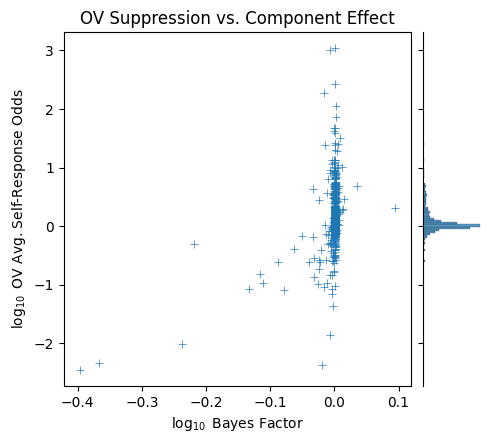

In [10]:
g = sns.jointplot(
    data=dfm,
    x="log10_bf_nc_c",
    y="mean_minus_offdiag",
    alpha=1,
    marker="+",
    height=5,
)
g.ax_marg_x.remove()

# Add back in plot border on top
g.ax_joint.spines["top"].set_visible(True)
g.ax_joint.spines["right"].set_visible(True)

plt.xlabel("$\log_{10}$ Bayes Factor")
plt.ylabel("$\log_{10}$ OV Avg. Self-Response Odds")
plt.title("OV Suppression vs. Component Effect")
plt.show()

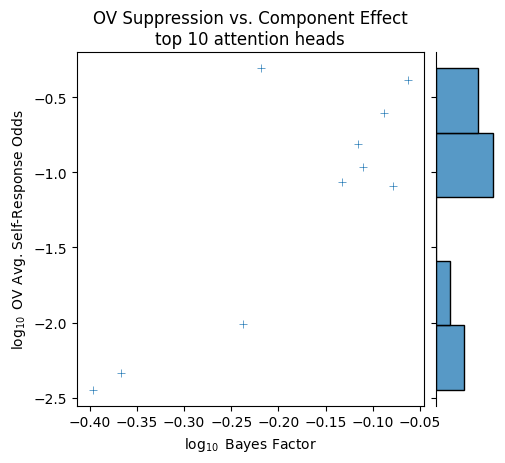

In [11]:
# n_attn_heads = ATN_HEAD_LABEL_MASK[:48].sum()
n_attn_heads = 10
g = sns.jointplot(
    data=dfm[:n_attn_heads],
    x="log10_bf_nc_c",
    y="mean_minus_offdiag",
    alpha=1,
    marker="+",
    height=5,
)
g.ax_marg_x.remove()

# Add back in plot border on top
g.ax_joint.spines["top"].set_visible(True)
g.ax_joint.spines["right"].set_visible(True)

plt.xlabel("$\log_{10}$ Bayes Factor")
plt.ylabel("$\log_{10}$ OV Avg. Self-Response Odds")
plt.title(
    "\n".join(
        [
            "OV Suppression vs. Component Effect",
            f"top {n_attn_heads} attention heads",
        ]
    )
)
plt.show()

In [12]:
dfm.sort_values("mean_minus_offdiag", ascending=True).head(10)

,layer,head,mean_diag,mean_offdiag,std_diag,std_offdiag,log10_bf_nc_c,mean_minus_offdiag
0,18,9,-7.838050,-5.390689,1.471214,0.848910,-0.396966,-2.447361
22,26,28,-7.787235,-5.421110,1.733930,0.839473,-0.018783,-2.366125
1,27,29,-8.176431,-5.839364,2.637320,0.917876,-0.366975,-2.337067
2,26,9,-7.579601,-5.571556,2.104035,0.872430,-0.237994,-2.008045
41,23,18,-7.255518,-5.399527,1.276997,0.862872,-0.006311,-1.855991
64,15,25,-6.587431,-5.228394,0.979849,0.776308,-0.001869,-1.359037
49,17,1,-6.523144,-5.369242,1.336795,0.816607,-0.003924,-1.153902
8,26,14,-7.490551,-6.401041,1.675388,1.157247,-0.078905,-1.089510
50,31,26,-7.051969,-5.974747,2.028781,0.954212,-0.003739,-1.077222
4,19,23,-6.477479,-5.412203,1.372011,0.829208,-0.132331,-1.065276


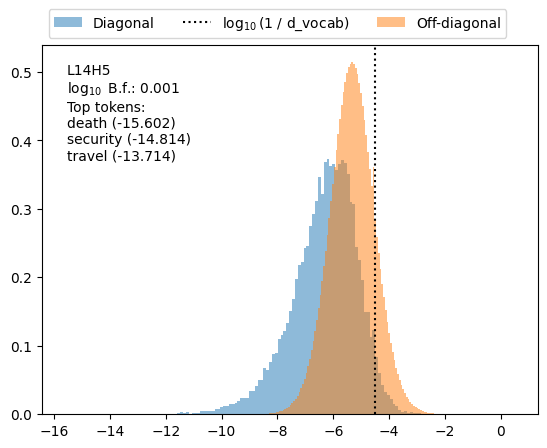

In [15]:
plot_ov_resp_matrix(layer=14, head=5, top_tokens=3)
plt.legend(bbox_to_anchor=(0, 1), loc="lower left", ncol=3)
plt.show()